# Slice interpolation for labels in zarpaint

## Resources

* Paper:  Raya and Udupa "Shape-Based Interpolation of Multidimensional Objects" IEEE TRANSACTIONS ON MEDICAL IMAGING, VOL. 9, NO. I , MARCH 1990
* [This StackOverflow post](https://stackoverflow.com/questions/48818373/interpolate-between-two-images) (not well executed for nd, but useful to read anyway)


In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile

In [20]:
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import interpn

In [10]:
import napari

In [12]:
viewer = napari.Viewer()
viewer.open_sample('napari', 'cells3d')
membrane_layer = viewer.layers[0]
nuclei_layer = viewer.layers[1]

/Users/genevieb/mambaforge/envs/napari-empanada/lib/python3.9/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
/Users/genevieb/mambaforge/envs/napari-empanada/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [ ]:
single_nuclei_label = tifffile.imread('single-nuclei-label.tif')
viewer.add_labels(single_nuclei_label)
label_layer = viewer.layers[-1]
labels = label_layer.data

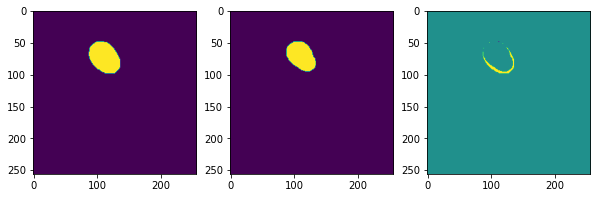

In [21]:
first_slice = 30
last_slice = 38
image_1 = labels[first_slice, ...]
image_2 = labels[last_slice, ...]

diff = labels[first_slice, ...] - labels[last_slice, ...]

fig, ax = plt.subplots(ncols=3, figsize=(10,3))
ax[0].imshow(image_1)
ax[1].imshow(image_2)
ax[2].imshow(diff)

In [27]:
from scipy.ndimage import distance_transform_edt

def distance_transform(image):
    """Distance transform for a boolean image.
    
    Returns positive values inside the object,
    and negative values outside.
    """
    image = image.astype(bool)
    edt = distance_transform_edt(image) - distance_transform_edt(~image)
    return edt

-202.5660386145713 -84.07044179766024 20.518284528683193
-206.0218435020908 -86.68854786664434 18.788294228055936


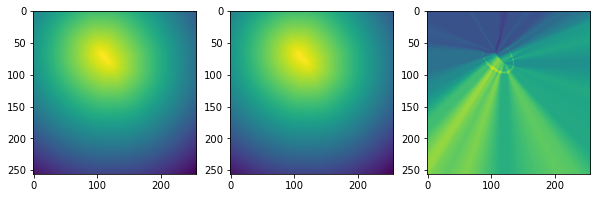

In [29]:
edt_1 = distance_transform(image_1)
edt_2 = distance_transform(image_2)

print(np.min(edt_1), np.mean(edt_1), np.max(edt_1))
print(np.min(edt_2), np.mean(edt_2), np.max(edt_2))

fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].imshow(edt_1)
ax[1].imshow(edt_1)
ax[2].imshow(edt_1 - edt_2)

In [56]:
dim_for_interpolation = 0
values = np.stack([edt_1, edt_2], axis=dim_for_interpolation)
print(values.shape)
points = tuple([np.arange(i) for i in values.shape])
print(points)

(2, 256, 256)
(array([0, 1]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 17

In [189]:
import numpy as np

def xi_coords(shape, percent=0.5):
    slices = [slice(0, i) for i in shape]
    xi = np.moveaxis(np.mgrid[slices], 0, -1).reshape(np.prod(shape), len(shape))
    xi = xi = np.c_[np.full((np.prod(shape)), percent), xi]
    return xi

xi = xi_coords(image_1.shape, percent=0.5)
print(xi.shape)
print(xi)

(65536, 3)
[[  0.5   0.    0. ]
 [  0.5   0.    1. ]
 [  0.5   0.    2. ]
 ...
 [  0.5 255.  253. ]
 [  0.5 255.  254. ]
 [  0.5 255.  255. ]]


In [236]:
def slice_iterator(slice_index_1, slice_index_2):
    intermediate_slices = np.arange(slice_index_1 + 1, slice_index_2)
    n_slices = slice_index_2 - slice_index_1 + 1  # inclusive
    stepsize = 1 / n_slices
    intermediate_percentages = np.arange(0 + stepsize, 1, stepsize)
    return zip(intermediate_slices, intermediate_percentages)

def interpolated_slice(percent, points, values, **kwargs):
    xi = xi_coords(img_shape, percent=0.5)
    interpolated_img = interpn(points, values, xi, **kwargs)
    interpolated_img = np.reshape(interpolated, shape) > 0
    return interpolated_img
    
def interpolate_between_slices(image_1, image_2, slice_index_1, slice_index_2, interpolation_dimension=0, **kwargs):
    if slice_index_1 > slice_index_2:
        image_1, image_2 = image_2, image_1
        slice_index_1, slice_index_2 = slice_index_2, slice_index_1
    ####
    # possible extension, handle all label ids separately
    label_id = 1
    image_1 = image_1.astype(bool)
    image_2 = image_2.astype(bool)
    ####
    edt_1 = distance_transform(image_1)
    edt_2 = distance_transform(image_2)
    values = np.stack([edt_1, edt_2], axis=interpolation_dimension)
    points = tuple([np.arange(i) for i in values.shape])

    output = []
    for slice_number, percentage in slice_iterator(slice_index_1, slice_index_2):
        interpolated_img = interpolated_slice(percent, points, values, **kwargs)
        output.append(interpolated_img)
    output = np.array(output)
    return output

In [234]:
result = interpolate_between_slices(image_1, image_2, 30, 38)
result.shape

(7, 256, 256)

In [235]:
viewer.dims

Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 60.0, 1.0), (0.0, 256.0, 1.0), (0.0, 256.0, 1.0)), current_step=(0, 128, 128), order=(0, 1, 2), axis_labels=('0', '1', '2'))

(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


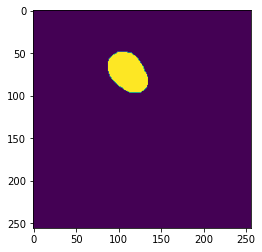

In [191]:
import numpy as np
from scipy.interpolate import interpn

img_shape = edt_1.shape
values = np.stack([edt_1, edt_2], axis=0)
points = tuple([np.arange(i) for i in values.shape])
xi = xi_coords(img_shape, percent=0.5)
interpolated = interpn(points, values, xi, method='linear')
result = np.reshape(interpolated, shape) > 0

print(result.shape)
print(result)
plt.imshow(result)


In [203]:
outputs = []

percentages = np.arange(0, 1.1, 0.1)
for percent in percentages:
    xi = xi_coords(img_shape, percent=percent)
    interpolated = interpn(points, values, xi, method='linear')
    out = np.reshape(interpolated, shape) > 0
    outputs.append(out)
outputs = np.array(outputs)

## Visualization

In [205]:
viewer.add_labels(outputs)

<Labels layer 'outputs' at 0x29a6997f0>

In [206]:
viewer.add_labels(image_1)
viewer.add_labels(image_2)

<Labels layer 'image_2' at 0x29a7299d0>

## Test cases
* a simple 3D test case (interpolating 2D slices)
  * assert when percent = 0, the result exactly matches the input image_1
  * assert when percent = 1.0, the result exactly matches the input image_2
  * check results against a previous computation
* A test case with multiple label id values
* A 4D test case (interpolate across time points, from two labelled 3d blobs)
* Check code is robust as to which order image_2 and image_2 are given (eg: user can be scrolling forwards OR backwards through the slices)
* A test case when the structure is branching (one input blob turns into two output blobs)